In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy import stats
from functools import partial
import pickle
from tqdm import tqdm

## function definition

In [13]:
def poisson_dist(x, l):
    return np.exp(-l)*np.power(l, x)/factorial(x)

def normal_dist(x, mean , sd):
    sqrt_2pi = np.sqrt(2*np.pi)
    prob_density = 1.0/(sqrt_2pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

def uniform_dist(x, a, b):
    return (x*0 + 1) * (1.0 / (b-a))

def sin_dist(x):
    return np.abs(np.sin(x/2)) * 0.2

def sin_damping_dist(x):
    return np.abs(np.sin(x/2)) * 0.2 * np.exp(-x/5)

## CheckPoint structure

In [14]:
class CheckPoint:
    x                = None
    target_dist      = None
    target_dist_name = 'poisson'
    
    def __init__(self, it, samples, prob_dist):
        plt.style.use('seaborn-pastel')
        self.it = it
        self.samples = np.array(samples)
        self.prob_dist = prob_dist.copy()
        
    def plot_compare(self):
        x = CheckPoint.x
        target_dist = CheckPoint.target_dist
        target_dist_name = CheckPoint.target_dist_name
        it = self.it
        samples = self.samples
        prob_dist = self.prob_dist
        
        if x is None or target_dist is None:
            raise Exception('target_dist is None')
            
        plt.figure()
        plt.title(str(it) + "-th iteration")
        
        plt.plot(x, target_dist, label=target_dist_name) 
        plt.fill_between(x, target_dist, 0, alpha=1)
        
        plt.plot(x, prob_dist, label="current P.D.") 
        plt.fill_between(x, prob_dist, 0, alpha=0.2)
        
        plt.xlim(0, x[-1]), plt.ylim(0, 1), plt.xlabel("x"), plt.ylabel("y"), plt.legend();
        plt.savefig('MH-iter%d.jpg' % it, dpi=300)
        
    def plot_compare_hist(self, max_iter = None):
        x = CheckPoint.x
        target_dist = CheckPoint.target_dist
        target_dist_name = CheckPoint.target_dist_name
        it = self.it
        samples = self.samples
        prob_dist = self.prob_dist
        
        if x is None or target_dist is None:
            raise Exception('target_dist is None')
            
        plt.figure()
        plt.title(str(it) + "-th iteration")
        
        plt.plot(x, target_dist, label=target_dist_name) 
        plt.fill_between(x, target_dist, 0, alpha=1)
        
        if max_iter is not None:
            samples_dummy = np.ones(max_iter - samples.size) * -1
            samples = np.concatenate((samples_dummy, samples))
        plt.hist(samples, bins = 100, density = True, label="current samples")
        
        plt.xlim(0, x[-1]), plt.ylim(0, 1), plt.xlabel("x"), plt.ylabel("y"), plt.legend();
        if max_iter is None:
            plt.savefig('MH-iter%d-bins.jpg' % it, dpi=300)
        else:
            plt.savefig('MH-iter%d-bins-norm.jpg' % it, dpi=300)

## Metropolis-Hastings on Poisson Distribution with Normal Distribution

In [18]:
disable_acceptance_ratio = False

points_per_x = 1000
x_min        = 0
x_max        = 20

poisson_lambda = 5
normal_std     = 1

x          = np.linspace(x_min, x_max, (x_max-x_min)*points_per_x)
y_poisson  = poisson_dist(x, 5)

CheckPoint.x                = x
CheckPoint.target_dist      = y_poisson
CheckPoint.target_dist_name = 'poisson'

state_sampled = []
max_iter = 10000
checkpoints_iter = set([
    0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90,
    100, 200, 500,
    1000, 2000, 3000, 5000, 8000,
    10000, 20000, 30000, 40000, 50000, 100000, 200000, max_iter])
checkpoints = []
reject_cnt = 0
accept_cnt = 0

init_state = 15.0
state = init_state
y_prob = np.zeros(x.size)

for t in tqdm(range(max_iter+1)):
    
    state_sampled.append(state)
    
    # (x, y) coordinate of current state
    state_xidx = np.where(x <= state)[0][-1]
    state_yval = y_poisson[state_xidx]
    
    # acceptance ratio = (P_nxt / P_now) * (g_nxt_to_now / g_now_to_nxt)
    P_nxt        = y_poisson
    P_now        = state_yval
    g_nxt_to_now = normal_dist(state, x, normal_std)
    g_now_to_nxt = normal_dist(x, state, normal_std) + 1E-9 # prevent divide by zero
    acceptance_ratio = (P_nxt / P_now) * (g_nxt_to_now / g_now_to_nxt)
    acceptance_ratio[acceptance_ratio > 1] = 1
    if disable_acceptance_ratio:
        acceptance_ratio = 1
    
    # calculate overall P.D.
    y_proposal = normal_dist(x, state, normal_std)
    y_prob = ((y_prob * t) + (y_proposal * acceptance_ratio)) / (t+1)
    # normalize y_prob
    y_prob = y_prob * 1000.0 / np.sum(y_prob)
    
    # show figure
    if t in checkpoints_iter:
        print("Save checkpoint at iter %d, state = %f" % (t, state))
        
        checkpoint = CheckPoint(t, state_sampled, y_prob)
        checkpoints.append(checkpoint)
    
    # update next
    state_nxt = -1
    # if state_nxt < 0, then state_nxt_yval = 0, i.e., accept_prob = 0
    while (state_nxt < 0):
        state_nxt = np.random.normal(state, normal_std)
    state_nxt_xidx = np.where(x <= state_nxt)[0][-1]
    state_nxt_yval = y_poisson[state_nxt_xidx]
    accept_prob = (state_nxt_yval / state_yval) * (normal_dist(state, state_nxt, normal_std) / normal_dist(state_nxt, state, normal_std))
    if disable_acceptance_ratio:
        accept_prob = 1
    if accept_prob >= 1:
        state = state_nxt
        accept_cnt += 1
    else:
        u = np.random.uniform()
        if (u <= accept_prob):
            state = state_nxt
            accept_cnt += 1
        else:
            state = state
            reject_cnt += 1

print("# of accept: %d" % accept_cnt)
print("# of reject: %d" % reject_cnt)


100%|██████████| 1/1 [00:00<00:00, 309.31it/s]

Save checkpoint at iter 0, state = 15.000000
# of accept: 1
# of reject: 0


## Metropolis-Hastings on Poisson Distribution with Uniform Distribution

In [20]:
# points_per_x = 1000
# x_min        = 0
# x_max        = 20

# poisson_lambda = 5

# x          = np.linspace(x_min, x_max, (x_max-x_min)*points_per_x)
# y_poisson  = poisson_dist(x, 5)

# CheckPoint.x                = x
# CheckPoint.target_dist      = y_poisson
# CheckPoint.target_dist_name = 'poisson'

# state_sampled = []
# max_iter = 10000
# checkpoints_iter = set([
#     0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90,
#     100, 200, 500,
#     1000, 2000, 3000, 5000, 8000,
#     10000, 20000, 30000, 40000, 50000, max_iter])
# checkpoints = []
# reject_cnt = 0
# accept_cnt = 0

# init_state = 10.0
# state = init_state
# y_prob = np.zeros(x.size)

# for t in tqdm(range(max_iter+1)):
    
#     state_sampled.append(state)
    
#     # (x, y) coordinate of current state
#     state_xidx = np.where(x <= state)[0][-1]
#     state_yval = y_poisson[state_xidx]
    
#     # acceptance ratio = (P_nxt / P_now) * (g_nxt_to_now / g_now_to_nxt)
#     P_nxt        = y_poisson
#     P_now        = state_yval
#     # g_nxt_to_now = uniform_dist(x, x_min, x_max)
#     # g_now_to_nxt = uniform_dist(x, x_min, x_max)
#     # acceptance_ratio = (P_nxt / P_now) * (g_nxt_to_now / g_now_to_nxt)
#     acceptance_ratio = (P_nxt / P_now)
#     acceptance_ratio[acceptance_ratio > 1] = 1
    
#     # calculate overall P.D.
#     y_proposal = uniform_dist(x, x_min, x_max)
#     y_prob = ((y_prob * t) + (y_proposal * acceptance_ratio)) / (t+1)
#     # normalize y_prob
#     y_prob = y_prob * 1000.0 / np.sum(y_prob)
    
#     # show figure
#     if t in checkpoints_iter:
#         print("Save checkpoint at iter %d, state = %f" % (t, state))
        
#         checkpoint = CheckPoint(t, state_sampled, y_prob)
#         checkpoints.append(checkpoint)
    
#     # update next
#     state_nxt = -1
#     # if state_nxt < 0, then state_nxt_yval = 0, i.e., accept_prob = 0
#     while (state_nxt < 0):
#         state_nxt = np.random.uniform(0, 20)
#     state_nxt_xidx = np.where(x <= state_nxt)[0][-1]
#     state_nxt_yval = y_poisson[state_nxt_xidx]
#     # accept_prob = (state_nxt_yval / state_yval) * (uniform_dist(0, x_min, x_max) / uniform_dist(0, x_min, x_max))
#     accept_prob = (state_nxt_yval / state_yval)
#     if accept_prob >= 1:
#         state = state_nxt
#         accept_cnt += 1
#     else:
#         u = np.random.uniform()
#         if (u <= accept_prob):
#             state = state_nxt
#             accept_cnt += 1
#         else:
#             state = state
#             reject_cnt += 1

# print("# of accept: %d" % accept_cnt)
# print("# of reject: %d" % reject_cnt)


100%|██████████| 1/1 [00:00<00:00, 577.01it/s]

Save checkpoint at iter 0, state = 10.000000
# of accept: 1
# of reject: 0


## Metropolis-Hastings on Damping Sine Function with Normal Distribution

In [467]:
# disable_acceptance_ratio = False

# points_per_x = 1000
# x_min        = 0
# x_max        = 20

# poisson_lambda = 5
# normal_std     = 0.1

# x      = np.linspace(x_min, x_max, (x_max-x_min)*points_per_x)
# # y_sine = sin_dist(x)
# y_sine = sin_damping_dist(x)
# y_sine[np.where(x<=np.pi*2*3)[0][-1]:] = 0
# y_sine = y_sine * 1000.0 / np.sum(y_sine)

# CheckPoint.x                = x
# CheckPoint.target_dist      = y_sine
# CheckPoint.target_dist_name = 'damped-sine'

# state_sampled = []
# max_iter = 500000
# checkpoints_iter = set([
#     0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90,
#     100, 200, 500,
#     1000, 2000, 3000, 5000, 8000,
#     10000, 20000, 30000, 40000, 50000, 100000, 200000, 300000, 400000, 500000,
#     max_iter])
# checkpoints = []
# reject_cnt = 0
# accept_cnt = 0

# init_state = 15.0
# state = init_state
# y_prob = np.zeros(x.size)

# for t in tqdm(range(max_iter+1)):
    
#     state_sampled.append(state)
    
#     # (x, y) coordinate of current state
#     state_xidx = np.where(x <= state)[0][-1]
#     state_yval = y_sine[state_xidx]
    
#     # acceptance ratio = (P_nxt / P_now) * (g_nxt_to_now / g_now_to_nxt)
#     P_nxt        = y_sine
#     P_now        = state_yval
#     g_nxt_to_now = normal_dist(state, x, normal_std)
#     g_now_to_nxt = normal_dist(x, state, normal_std) + 1E-9 # prevent divide by zero
#     acceptance_ratio = (P_nxt / P_now) * (g_nxt_to_now / g_now_to_nxt)
#     acceptance_ratio[acceptance_ratio > 1] = 1
#     if disable_acceptance_ratio:
#         acceptance_ratio = 1
    
#     # calculate overall P.D.
#     y_proposal = normal_dist(x, state, normal_std)
#     y_prob = ((y_prob * t) + (y_proposal * acceptance_ratio)) / (t+1)
#     # normalize y_prob
#     y_prob = y_prob * 1000.0 / np.sum(y_prob)
    
#     # show figure
#     if t in checkpoints_iter:
#         print("Save checkpoint at iter %d, state = %f" % (t, state))
        
#         checkpoint = CheckPoint(t, state_sampled, y_prob)
#         checkpoints.append(checkpoint)
    
#     # update next
#     state_nxt = -1
#     # if state_nxt < 0, then state_nxt_yval = 0, i.e., accept_prob = 0
#     while (state_nxt < 0):
#         state_nxt = np.random.normal(state, normal_std)
#     state_nxt_xidx = np.where(x <= state_nxt)[0][-1]
#     state_nxt_yval = y_sine[state_nxt_xidx]
#     accept_prob = (state_nxt_yval / state_yval) * (normal_dist(state, state_nxt, normal_std) / normal_dist(state_nxt, state, normal_std))
#     if disable_acceptance_ratio:
#         accept_prob = 1
#     if accept_prob >= 1:
#         state = state_nxt
#         accept_cnt += 1
#     else:
#         u = np.random.uniform()
#         if (u <= accept_prob):
#             state = state_nxt
#             accept_cnt += 1
#         else:
#             state = state
#             reject_cnt += 1

# print("# of accept: %d" % accept_cnt)
# print("# of reject: %d" % reject_cnt)


  0%|          | 606/500001 [00:00<02:41, 3098.47it/s]

Save checkpoint at iter 0, state = 15.000000
Save checkpoint at iter 5, state = 14.683157
Save checkpoint at iter 10, state = 15.322992
Save checkpoint at iter 20, state = 15.110753
Save checkpoint at iter 30, state = 14.673574
Save checkpoint at iter 40, state = 14.682558
Save checkpoint at iter 50, state = 14.600156
Save checkpoint at iter 60, state = 14.942685
Save checkpoint at iter 70, state = 15.052497
Save checkpoint at iter 80, state = 15.008342
Save checkpoint at iter 90, state = 15.299841
Save checkpoint at iter 100, state = 15.295787
Save checkpoint at iter 200, state = 14.222166
Save checkpoint at iter 500, state = 15.792882


  0%|          | 1638/500001 [00:00<02:28, 3367.30it/s]

Save checkpoint at iter 1000, state = 15.531687


  1%|          | 2659/500001 [00:00<02:26, 3383.52it/s]

Save checkpoint at iter 2000, state = 16.486715


  1%|          | 3680/500001 [00:01<02:26, 3376.65it/s]

Save checkpoint at iter 3000, state = 13.411319


  1%|          | 5387/500001 [00:01<02:28, 3328.58it/s]

Save checkpoint at iter 5000, state = 9.742307


  2%|▏         | 8410/500001 [00:02<02:26, 3357.01it/s]

Save checkpoint at iter 8000, state = 7.846575


  2%|▏         | 10435/500001 [00:03<02:25, 3366.54it/s]

Save checkpoint at iter 10000, state = 9.975678


  4%|▍         | 20583/500001 [00:06<02:23, 3344.61it/s]

Save checkpoint at iter 20000, state = 8.289802


  6%|▌         | 30402/500001 [00:09<02:19, 3359.61it/s]

Save checkpoint at iter 30000, state = 5.378208


  8%|▊         | 40670/500001 [00:12<02:13, 3429.76it/s]

Save checkpoint at iter 40000, state = 5.030749


 10%|█         | 50675/500001 [00:14<02:11, 3410.15it/s]

Save checkpoint at iter 50000, state = 3.652072


 20%|██        | 100590/500001 [00:29<01:58, 3380.34it/s]

Save checkpoint at iter 100000, state = 4.560385


 40%|████      | 200380/500001 [00:58<01:28, 3383.31it/s]

Save checkpoint at iter 200000, state = 4.136842


 60%|██████    | 300576/500001 [01:28<00:59, 3329.40it/s]

Save checkpoint at iter 300000, state = 7.405660


 80%|████████  | 400388/500001 [01:57<00:30, 3311.29it/s]

Save checkpoint at iter 400000, state = 9.534544


100%|██████████| 500001/500001 [02:26<00:00, 3415.67it/s]

Save checkpoint at iter 500000, state = 2.899345
# of accept: 489813
# of reject: 10188


## Checkpoints plotting

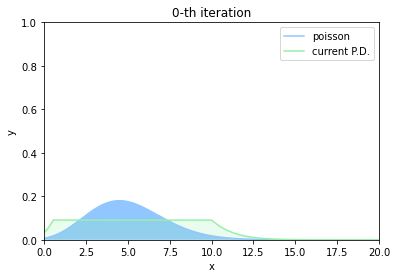

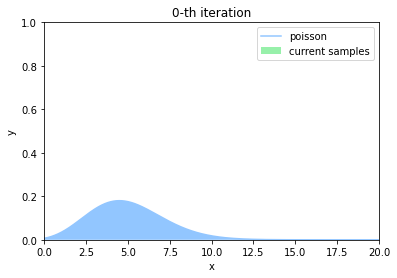

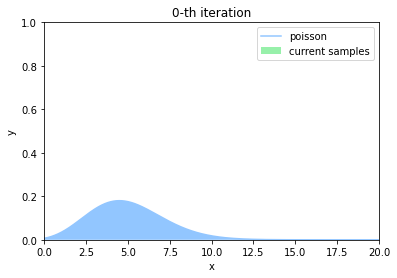

In [21]:
for checkpoint in checkpoints:
    checkpoint.plot_compare()
    
for checkpoint in checkpoints:
    checkpoint.plot_compare_hist()

for checkpoint in checkpoints:
    checkpoint.plot_compare_hist(max_iter)